<a href="https://colab.research.google.com/github/alan-w25/ese4380-project/blob/main/ESE_5380_Regime_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline: K-Means Regimes

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

M_ou_df  = pd.read_csv("/content/drive/MyDrive/TSML Moment Datasets/OU Moments.csv",
                       header=None)
M_dw_df  = pd.read_csv("/content/drive/MyDrive/TSML Moment Datasets/Double Well Moments.csv",
                       header=None)
M_cir_df = pd.read_csv("/content/drive/MyDrive/TSML Moment Datasets/Cir Moments.csv",
                       header=None)

M_ou  = M_ou_df.to_numpy(dtype=float)
M_dw  = M_dw_df.to_numpy(dtype=float)
M_cir = M_cir_df.to_numpy(dtype=float)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


mt+1​≈A(r)mt​+b(r)(regime r).

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
import numpy.linalg as la

def fit_regime_model(M, n_regimes=3, alpha=1e-3, random_state=0):
    """
    Fit a K-means + per-regime linear operator model on a moment time series.

    Parameters
    ----------
    M : np.ndarray, shape (T, K)
        Moment time series (rows = time, cols = moment orders).
    n_regimes : int
        Number of regimes (clusters).
    alpha : float
        Ridge regularization strength.
    random_state : int
        Random seed for KMeans.

    Returns
    -------
    model : dict with keys
        'kmeans'           : fitted KMeans object
        'operators'        : list of (A_r, b_r) for each regime r
        'regime_labels'    : np.ndarray of length T-1 with regime labels for X
        'spectral_radii'   : list of spectral radius for each A_r
        'n_regimes'        : number of regimes
    """
    M = np.asarray(M)
    T, K = M.shape

    # one-step pairs
    X = M[:-1]   # m_t
    Y = M[1:]    # m_{t+1}

    # K-means clustering on current state m_t
    kmeans = KMeans(n_clusters=n_regimes, random_state=random_state, n_init=20)
    regime_labels = kmeans.fit_predict(X)

    # per-regime linear operators
    operators = []
    for r in range(n_regimes):
        idx = np.where(regime_labels == r)[0]
        X_r, Y_r = X[idx], Y[idx]

        reg = Ridge(alpha=alpha, fit_intercept=True)
        reg.fit(X_r, Y_r)

        A_r = reg.coef_       # (K, K)
        b_r = reg.intercept_  # (K,)
        operators.append((A_r, b_r))

    spectral_radii = [max(abs(la.eigvals(A))) for (A, _) in operators]

    model = {
        "kmeans": kmeans,
        "operators": operators,
        "regime_labels": regime_labels,
        "spectral_radii": spectral_radii,
        "n_regimes": n_regimes,
    }
    return model


In [ ]:
def step_forward(m_t, model):
    """
    One-step prediction given current moment vector m_t and a fitted model dict.
    """
    kmeans = model["kmeans"]
    operators = model["operators"]

    regime = kmeans.predict(m_t.reshape(1, -1))[0]
    A_r, b_r = operators[regime]
    m_next = A_r @ m_t + b_r
    return m_next, regime


def rollout(M, model, h=10, start_idx=0):
    """
    Closed-loop rollout for horizon h starting from time start_idx.

    Parameters
    ----------
    M : np.ndarray, shape (T, K)
        Moment time series used as ground truth.
    model : dict
        Output of fit_regime_model.
    h : int
        Horizon (number of steps to roll).
    start_idx : int
        Starting time index.

    Returns
    -------
    preds   : np.ndarray, shape (h+1, K)
              Predicted moment path (including initial state).
    regimes : np.ndarray, shape (h,)
              Regime indices used at each step.
    """
    M = np.asarray(M)
    m_hat = M[start_idx].copy()
    preds = [m_hat]
    regimes = []

    for _ in range(h):
        m_hat, r = step_forward(m_hat, model)
        preds.append(m_hat)
        regimes.append(r)

    return np.array(preds), np.array(regimes)


def multi_horizon_mse(M, model, h=10, n_starts=50, seed=0):
    """
    Average multi-step MSE over random starting points.
    """
    M = np.asarray(M)
    T, K = M.shape
    rng = np.random.default_rng(seed)
    starts = rng.integers(low=0, high=T-h-1, size=n_starts)

    errs = []
    for s in starts:
        preds, _ = rollout(M, model, h=h, start_idx=s)
        true_seg = M[s:s+h+1]
        err = np.mean((preds[1:] - true_seg[1:])**2)  # ignore t0
        errs.append(err)

    return float(np.mean(errs))

In [ ]:
import matplotlib.pyplot as plt

def plot_rollout_vs_true(M, model, h=20, start_idx=None, n_moments_to_plot=3, seed=0, title=""):
    """
    Plot predicted vs true trajectories for the first few moments.
    """
    rng = np.random.default_rng(seed)
    M = np.asarray(M)
    T, K = M.shape

    if start_idx is None:
        # avoid going past the end
        start_idx = rng.integers(low=0, high=T - h - 1)

    preds, regimes = rollout(M, model, h=h, start_idx=start_idx)
    true_seg = M[start_idx:start_idx + h + 1]

    t_ax = np.arange(h + 1)  # relative time 0..h

    n_plot = min(n_moments_to_plot, K)

    plt.figure(figsize=(10, 6))
    for k in range(n_plot):
        plt.plot(t_ax, true_seg[:, k],
                 linestyle='-', marker='o', label=f"true m_{k+1}")
        plt.plot(t_ax, preds[:, k],
                 linestyle='--', marker='x', label=f"pred m_{k+1}")

    plt.xlabel("Steps ahead (relative time)")
    plt.ylabel("Moment value")
    plt.title(title or f"Rollout (start_idx={start_idx}, h={h})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Also useful: print the regime sequence used during rollout
    print("Regimes used during rollout:", regimes)


Run on 2 regimes

In [ ]:
# fit regime-switching operators
model_ou  = fit_regime_model(M_ou,  n_regimes=2, alpha=1e-3, random_state=0)
model_dw  = fit_regime_model(M_dw,  n_regimes=2, alpha=1e-3, random_state=0)
model_cir = fit_regime_model(M_cir, n_regimes=2, alpha=1e-3, random_state=0)

print("OU spectral radii:",  model_ou["spectral_radii"])
print("DW spectral radii:",  model_dw["spectral_radii"])
print("CIR spectral radii:", model_cir["spectral_radii"])

for h in [1, 5, 10]:
    mse_ou  = multi_horizon_mse(M_ou,  model_ou,  h=h, n_starts=50)
    mse_dw  = multi_horizon_mse(M_dw,  model_dw,  h=h, n_starts=50)
    mse_cir = multi_horizon_mse(M_cir, model_cir, h=h, n_starts=50)
    print(f"h = {h}:  OU {mse_ou:.3e} | DW {mse_dw:.3e} | CIR {mse_cir:.3e}")


OU spectral radii: [np.float64(0.9979207355185674), np.float64(0.9978035288417701)]
DW spectral radii: [np.float64(1.0495135656856365), np.float64(2.171737391537506)]
CIR spectral radii: [np.float64(0.997755811096413), np.float64(0.9977557930584298)]
h = 1:  OU 1.233e-03 | DW 8.650e-03 | CIR 1.915e-08
h = 5:  OU 1.708e-03 | DW 3.976e-02 | CIR 5.586e-08
h = 10:  OU 2.286e-03 | DW 8.493e+00 | CIR 9.326e-08


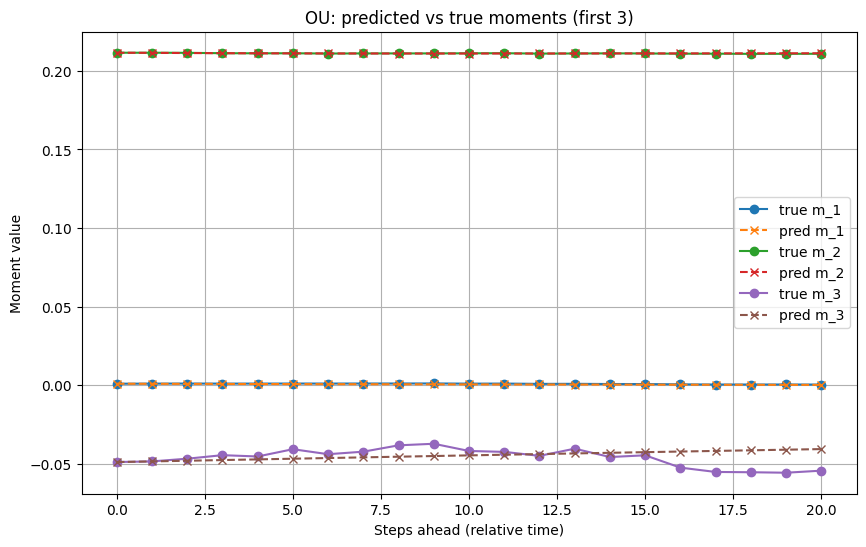

Regimes used during rollout: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


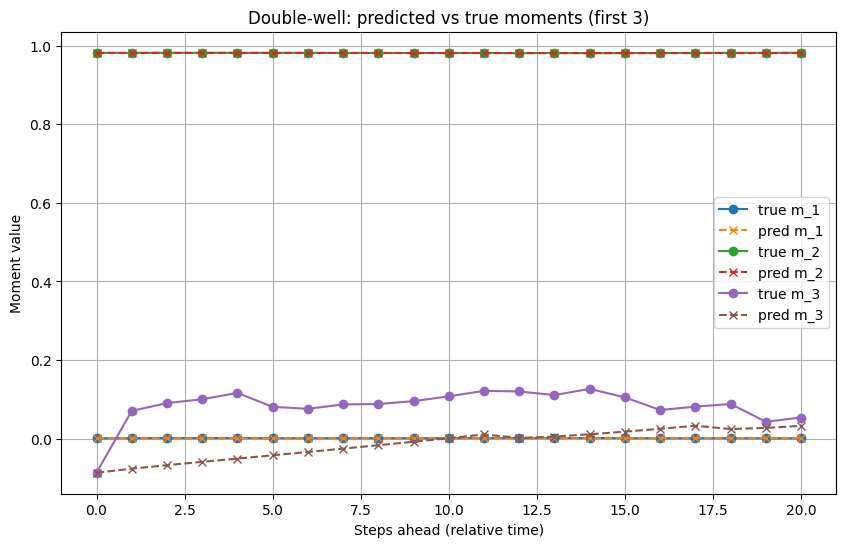

Regimes used during rollout: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]


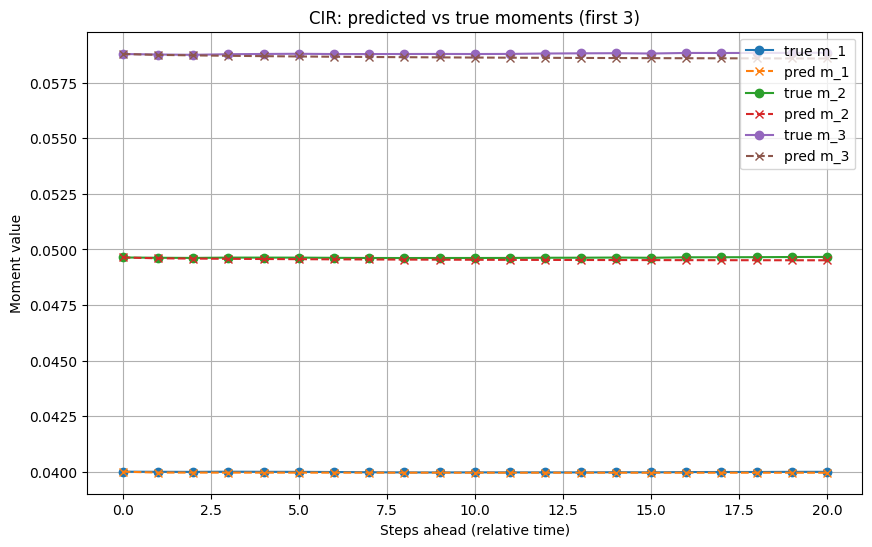

Regimes used during rollout: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# OU
plot_rollout_vs_true(
    M_ou, model_ou,
    h=20,
    seed=0,
    title="OU: predicted vs true moments (first 3)"
)

# Double-well
plot_rollout_vs_true(
    M_dw, model_dw,
    h=20,
    seed=1,
    title="Double-well: predicted vs true moments (first 3)"
)

# CIR
plot_rollout_vs_true(
    M_cir, model_cir,
    h=20,
    seed=2,
    title="CIR: predicted vs true moments (first 3)"
)


Run on 3 Regimes

In [ ]:
# fit regime-switching operators
model_ou  = fit_regime_model(M_ou,  n_regimes=3, alpha=1e-3, random_state=0)
model_dw  = fit_regime_model(M_dw,  n_regimes=3, alpha=1e-3, random_state=0)
model_cir = fit_regime_model(M_cir, n_regimes=3, alpha=1e-3, random_state=0)

print("OU spectral radii:",  model_ou["spectral_radii"])
print("DW spectral radii:",  model_dw["spectral_radii"])
print("CIR spectral radii:", model_cir["spectral_radii"])

for h in [1, 5, 10]:
    mse_ou  = multi_horizon_mse(M_ou,  model_ou,  h=h, n_starts=50)
    mse_dw  = multi_horizon_mse(M_dw,  model_dw,  h=h, n_starts=50)
    mse_cir = multi_horizon_mse(M_cir, model_cir, h=h, n_starts=50)
    print(f"h = {h}:  OU {mse_ou:.3e} | DW {mse_dw:.3e} | CIR {mse_cir:.3e}")


OU spectral radii: [np.float64(1.003445963486286), np.float64(1.2898804342659063), np.float64(0.9978294278923752)]
DW spectral radii: [np.float64(1.9723326792294404), np.float64(1.0373914872967491), np.float64(0.9945872101012775)]
CIR spectral radii: [np.float64(0.9955277110834806), np.float64(0.9966135657034613), np.float64(0.9928970777098223)]
h = 1:  OU 1.119e-03 | DW 8.328e-03 | CIR 1.854e-08
h = 5:  OU 1.757e-03 | DW 3.206e-02 | CIR 5.587e-08
h = 10:  OU 3.645e-03 | DW 1.029e+00 | CIR 9.917e-08


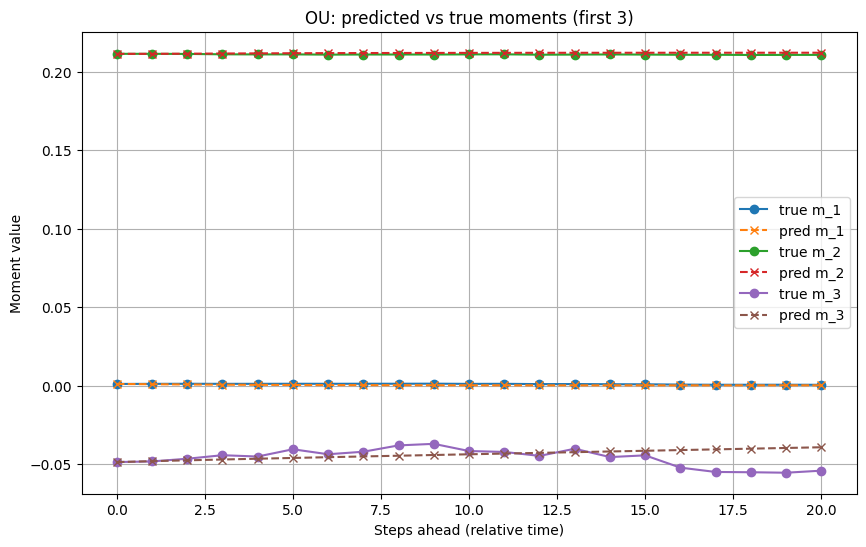

Regimes used during rollout: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


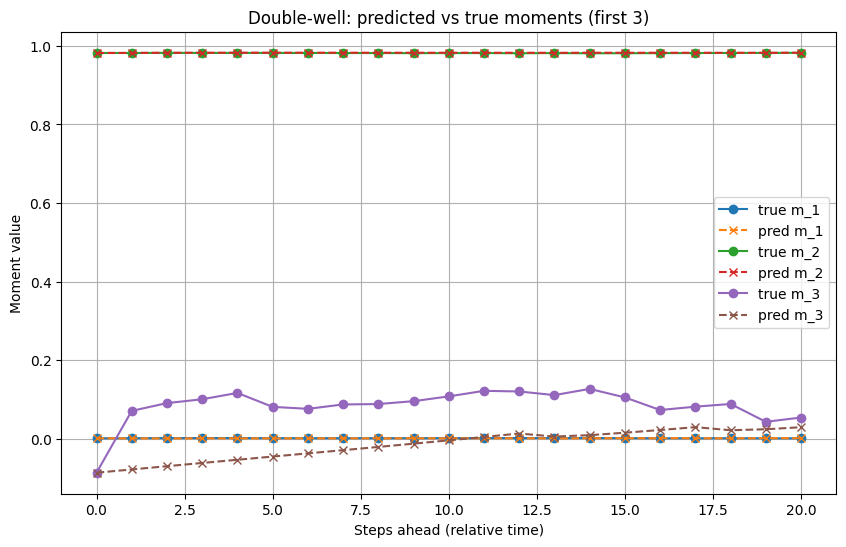

Regimes used during rollout: [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]


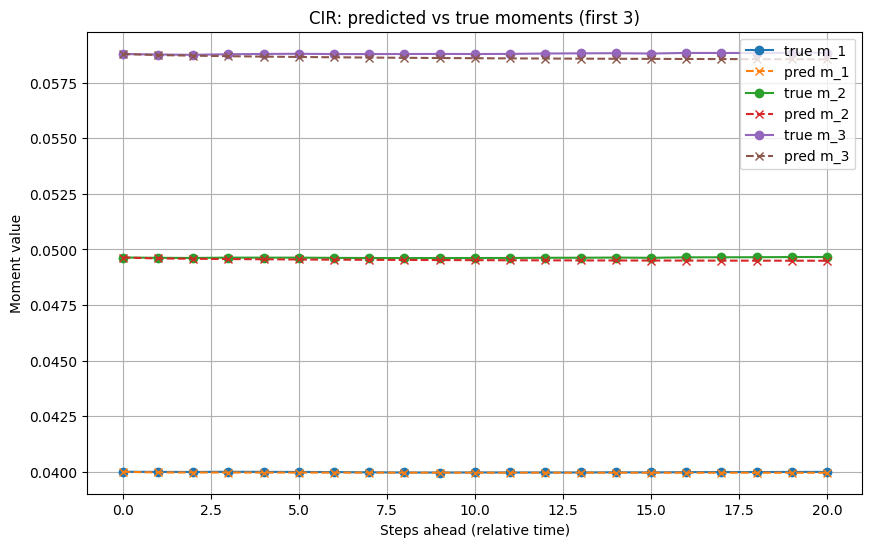

Regimes used during rollout: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# OU
plot_rollout_vs_true(
    M_ou, model_ou,
    h=20,
    seed=0,
    title="OU: predicted vs true moments (first 3)"
)

# Double-well
plot_rollout_vs_true(
    M_dw, model_dw,
    h=20,
    seed=1,
    title="Double-well: predicted vs true moments (first 3)"
)

# CIR
plot_rollout_vs_true(
    M_cir, model_cir,
    h=20,
    seed=2,
    title="CIR: predicted vs true moments (first 3)"
)

**Adding Lags**

In [ ]:
def build_lagged_features(M, p):
    """
    Build lagged features for a moment matrix M of shape (T, K).
    Produces:
        X_i = [m_i, m_{i-1}, ..., m_{i-p+1}]
        Y_i = m_{i+1}
    Outputs:
        X: (T - p, p*K)
        Y: (T - p, K)
        current_states_for_clustering: M[p:T]  (these correspond to X rows)
    """
    M = np.asarray(M)
    T, K = M.shape

    X = []
    Y = []

    for t in range(p, T-1):
        lag_block = []
        for j in range(p):
            lag_block.append(M[t-j])  # m_t, m_{t-1}, ..., m_{t-p+1}
        lag_block = np.concatenate(lag_block)

        X.append(lag_block)
        Y.append(M[t+1])

    X = np.array(X)                       # (T-p-1, p*K)
    Y = np.array(Y)                       # (T-p-1, K)
    C = M[p:T-1]                           # states corresponding to X rows

    return X, Y, C


In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
import numpy.linalg as la

def fit_regime_model_lags(M, p=1, n_regimes=3, alpha=1e-3, random_state=0):
    ...
    operators = []

    for r in range(n_regimes):
        idx = np.where(regime_labels == r)[0]
        X_r, Y_r = X[idx], Y[idx]

        reg = Ridge(alpha=alpha, fit_intercept=True)
        reg.fit(X_r, Y_r)

        A_r = reg.coef_      # (K, p*K)
        b_r = reg.intercept_ # (K,)
        operators.append((A_r, b_r))

    # --- spectral radii ---
    spectral_radii = []
    for (A_r, _) in operators:
        if p == 1:
            # simple square K×K case
            vals = la.eigvals(A_r)
        else:
            # build block companion matrix B_r of shape (pK, pK)
            K_dim, pK = A_r.shape
            assert pK == p * K_dim

            B = np.zeros((pK, pK))
            # top block row: A_r
            B[0:K_dim, :] = A_r

            # subdiagonal identity blocks
            for j in range(1, p):
                row_start = j * K_dim
                col_start = (j-1) * K_dim
                B[row_start:row_start+K_dim, col_start:col_start+K_dim] = np.eye(K_dim)

            vals = la.eigvals(B)

        spectral_radii.append(np.max(np.abs(vals)))

    return {
        "p": p,
        "kmeans": kmeans,
        "operators": operators,
        "regime_labels": regime_labels,
        "spectral_radii": spectral_radii,
        "n_regimes": n_regimes
    }



In [ ]:
def step_forward_lags(past_states, model):
    """
    past_states: list or array-like of length p, each of shape (K,)
                 [m_t, m_{t-1}, ..., m_{t-p+1}]
    """
    p = model["p"]
    kmeans = model["kmeans"]
    operators = model["operators"]

    m_t = past_states[0]                     # current m_t
    regime = kmeans.predict(m_t.reshape(1, -1))[0]

    A_r, b_r = operators[regime]

    x = np.concatenate(past_states[:p])      # shape (p*K,)
    m_next = A_r @ x + b_r

    return m_next, regime

def rollout_lags(M, model, h=10, start_idx=50):
    """
    Rollout for p-lag regime model.
    """
    M = np.asarray(M)
    p = model["p"]
    T, K = M.shape

    # gather the initial p states: [m_t, m_{t-1}, ..., m_{t-p+1}]
    past = [M[start_idx - j].copy() for j in range(p)]

    preds = [past[0]]
    regimes = []

    for _ in range(h):
        m_next, r = step_forward_lags(past, model)
        regimes.append(r)
        preds.append(m_next)

        # update lag buffer
        past = [m_next] + past[:p-1]

    return np.array(preds), np.array(regimes)


2 lags, 2 regimes

In [ ]:
model_ou_p2 = fit_regime_model_lags(M_ou, p=2, n_regimes=2)
model_dw_p2 = fit_regime_model_lags(M_dw, p=2, n_regimes=2)
model_cir_p2 = fit_regime_model_lags(M_cir, p=2, n_regimes=2)

print("OU spectral radii:",  model_ou_p2["spectral_radii"])
print("DW spectral radii:",  model_dw_p2["spectral_radii"])
print("CIR spectral radii:", model_cir_p2["spectral_radii"])


AssertionError: 

Add Poly Features

Vary Regularization

#Kernel Regression

# Mixture of Experts for softer regime membership

# HMM